Assumption: everyone declare exactly once for each round, knowing the message will propogate through the entire network.

In [2]:
!pip install qiskit
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=e9c7ac00cf6f2cb8c4644224667ce943b753c8595394c91ae0d055331cd2e42d
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


In [ ]:
import time
import random

from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute, BasicAer
import sys
import numpy as np
from qiskit.tools.visualization import plot_histogram

MsgType = ["declare_leader", "annonce_leader", "ack",
           "ELEC", "LEADER", # Chang & Roberts
           "APPLICATION", "QELEC"]

class Qbt():
    def __init__(self,circ,idx) -> None:
        self.circuit = circ
        self.idx = idx
        self.result = None

    def __repr__(self):
        return f"circ:circ, idx:{self.idx}, result:{self.result}"


class Qmsg():
    def __init__(self, sender, receiver, qubits, ) -> None:
        self.sender : int = sender
        self.receiver : int = receiver
        self.qubits : [[Qbt]] = qubits
        self.time_in_transit = -1

    def __repr__(self):
      return f"[src:{self.sender}, dest:{self.receiver}, qubits:{self.qubits}, countdown:{self.time_in_transit}]"


class Msg():
    def __init__(self, sender, receiver, msg_type, payload) -> None:
        self.sender : int = sender
        self.receiver : int = receiver
        self.type : MsgType = msg_type
        self.payload : (int | float | bool | str) | Qbt = payload
        self.time_in_transit = -1

    def __repr__(self):
      return f"[src:{self.sender}, dest:{self.receiver}, type:{self.type}, payload:{self.payload}, countdown:{self.time_in_transit}]"

class NodeState():
    def __init__(self, id) -> None:
        self.id = id
        self.clock = 0
        self.counter = 0

        # Chang & Roberts
        self.leader = None
        self.is_participant = False

        self.leader_validity = -1

class SysInfo():
    def __init__(self, total_num, neighbors, systm) -> None:
        self.total_num = -1
        self.neighbors = neighbors
        self.sys = systm
        self.validity = 30

class Node():
    def __init__(self, id, sys_info) -> None:
        self.state = NodeState(id)
        self.sys_info = sys_info
        self.msg_queue : [Msg] = []
        self.qmsg_queue : [Qmsg] = []
        self.qbt_memory : [Qbt] = []

    # simulation

    def _send_message(self, receiver, msg_type, payload):
        msg = Msg(self.state.id, receiver, msg_type, payload)
        self.sys_info.sys.transmit_message(msg)

    def _send_quantum_message(self, receiver, qubits):
        qmsg = Qmsg(self.state.id, receiver, qubits)
        self.sys_info.sys.transmit_quantum_message(qmsg)
        pass

    def _extract_message(self):
        if len(self.msg_queue) == 0:
          return None
        else:
          return self.msg_queue.pop(0)

    def _extract_quantum_message(self):
        if len(self.qmsg_queue) == 0:
          return None
        else:
          return self.qmsg_queue.pop(0)

    def _measure_qubit(self, ):
        self.sys_info.sys.measure_qubits(self.qbt_memory)
        pass

    def _generate_entanglement(self):
        qubits_list = self.sys_info.sys.generate_entanglement()
        return qubits_list

    def receive_message(self, msg):
        self.msg_queue.append(msg)

    def receive_quantum_message(self, qmsg):
        self.qmsg_queue.append(qmsg)

    # leader election

    def _calculate_id(self):
        s = 0
        num_of_pairs = int(np.ceil(np.log2(len(self.sys_info.sys.nodes))))
        for i in range(num_of_pairs):
            qubit = self.qbt_memory.pop(0)
            s = s * 2 + int(qubit.result)

        return s

    def _clear_quantum_memory(self):
        self.qbt_memory.clear()

    def process(self):
        # log info
        print(f'node {self.state.id} start processing...')
        print(f'self.state.is_participant:{self.state.is_participant}')
        msg = self._extract_message()
        while (msg is not None):
            print(f"\t{msg}")
            # process
            match msg.type:
                case "ELEC":
                    if self.state.id > msg.payload:
                        if not self.state.is_participant:
                            self._send_message(self.sys_info.neighbors[0], "ELEC",self.state.id)
                            self.state.is_participant = True
                            print("\trunning for leader")
                    elif self.state.id < msg.payload:
                        self._send_message(self.sys_info.neighbors[0], "ELEC", msg.payload)
                        self.state.is_participant = True
                        print(f"\tdefeated by node {msg.payload}")
                    elif self.state.id == msg.payload:
                        print(f"\telected as leader")

                        self._send_message(self.sys_info.neighbors[0], "LEADER", msg.payload)
                        self.state.is_participant = False
                        self.state.leader = self.state.id
                        self.state.leader_validity = self.sys_info.validity
                case "LEADER":
                    if self.state.id == msg.payload:
                        print("\teveryone learns the leader now")
                        entanglement_pairs = self._generate_entanglement()
                        for pair in entanglement_pairs:
                            self.qbt_memory.append(pair.pop(0))
                        self._send_quantum_message(self.sys_info.neighbors[0],entanglement_pairs)
                    else:
                        self.state.leader = msg.payload
                        self.state.leader_validity = self.sys_info.validity
                        print(f"\tlearned {self.state.leader} is the leader")
                        self.state.is_participant = False
                        self._send_message(self.sys_info.neighbors[0], "LEADER", msg.payload)
                case "APPLICATION":
                    print(f"\tprocessing application message...")
                case "QELEC":
                    if not self.state.is_participant:
                        self.state.is_participant = True
                        if len(self.qbt_memory) > 0:
                            self._measure_qubit()
                            leader = self._calculate_id()
                            if (leader != msg.payload):
                                print(f'ERROR: measurement does not mtach declaration')
                        # announce leadership
                        if msg.payload == self.state.id:
                            # if self.state.counter <= -1: # new
                            if True:
                                self._send_message(self.sys_info.neighbors[0], "QLEADER", msg.payload)
                                self.state.leader = msg.payload
                                self.state.leader_validity = self.sys_info.validity
                                self.state.is_participant = False
                                # self.state.counter == 0
                            # else: # new
                            #     self._send_message(self.sys_info.neighbors[0], "QELEC", msg.payload)
                            #     self.state.counter -= 1
                        # propogate declaration
                        else:
                            self._send_message(self.sys_info.neighbors[0], "QELEC", msg.payload)
                            # self.state.leader = leader
                            # self.state.leader_validity = self.sys_info.validity
                    else:
                        pass
                case "QLEADER":
                    if (msg.payload == self.state.id):
                        print(f'everyone learns the quantum leader')
                        entanglement_pairs = self._generate_entanglement()
                        for pair in entanglement_pairs:
                            self.qbt_memory.append(pair.pop(0))
                        self._send_quantum_message(self.sys_info.neighbors[0],entanglement_pairs)
                    else:
                        if len(self.qbt_memory) > 0:
                            self._measure_qubit()
                            leader = self._calculate_id()
                            if (leader != msg.payload):
                                print(f'ERROR: measurement does not mtach declaration')
                            else:
                                self.state.leader = leader
                        self.state.is_participant = False
                        self.state.leader = msg.payload
                        self.state.leader_validity = self.sys_info.validity
                        self._send_message(self.sys_info.neighbors[0], "QLEADER", msg.payload)
                    pass
                case _:
                    pass
            # end of match
            msg = self._extract_message()

        qmsg = self._extract_quantum_message()
        while (qmsg is not None):
            print(f"\t{qmsg}")
            # process
            self.state.is_participant = False
            entanglement_pairs = qmsg.qubits
            for pair in entanglement_pairs:
                self.qbt_memory.append(pair.pop(0))
            # print(self.qbt_memory)
            # print(entanglement_pairs)
            if len(entanglement_pairs[0]) > 0:
                self._send_quantum_message(self.sys_info.neighbors[0],entanglement_pairs)
            else:
                print("\teveryone gets entangled qubits now")
                pass

            qmsg = self._extract_quantum_message()

        if (self.state.leader is not None):
            self.state.leader_validity -= 1
            if (self.state.leader_validity <= -1):
                self.state.leader = None

        if (len(self.qbt_memory) > 0):
            if (self.state.leader is None) and (not self.state.is_participant):
                self._measure_qubit()
                leader = self._calculate_id()
                # self.state.leader = leader
                self.state.is_participant = True
                # self.state.leader_validity = self.sys_info.validity
                if (leader != self.state.id):
                    self._send_message(self.sys_info.neighbors[0], "QELEC", leader)
                else:
                    # self._send_message(self.sys_info.neighbors[0], "QELEC", leader)
                    # pass # new
                    self.state.leader = leader
                    self.state.leader_validity = self.sys_info.validity
                    self._send_message(self.sys_info.neighbors[0], "QLEADER", leader)
                    self.state.is_participant = False
            pass

        elif (not self.state.is_participant) and (self.state.leader is None):
          if random.random() <= 0.25:
            self.state.is_participant = True
            self._send_message(self.sys_info.neighbors[0], "ELEC", self.state.id)
            print("\trunning for leader")

        # send if conditions met
        print(f'\tcurrent leader: {self.state.leader}, validity:{self.state.leader_validity}, qubits in posession:{self.qbt_memory}')

class Sys():
    def __init__(self, n, kbd, topology) -> None:
        self.nodes : [Node] = []
        self.msg_in_flight : [Msg] = []
        self.qmsg_in_flight : [Qmsg] = list()
        self.time : int = 0
        self.max_delay : int = kbd
        self.n = n
        self.neighbors = topology
        self.running = True

        for i in range(n):
            self.create_node()

        self.circs = []
        self.results = []
        pass

    def create_node(self, ):
        id = len(self.nodes)
        print(self.neighbors[id])
        sys_info = SysInfo(self.n, self.neighbors[id], self)
        node = Node(id, sys_info)
        self.nodes.append(node)
        pass

    def transmit_message(self, msg):
        msg.time_in_transit = random.randint(1, self.max_delay)
        self.msg_in_flight.append(msg)
        pass

    def transmit_quantum_message(self, qmsg):
        qmsg.time_in_transit = random.randint(1, self.max_delay)
        self.qmsg_in_flight.append(qmsg)
        pass

    def find_node(self, id) -> Node:
      for node in self.nodes:
        if node.state.id == id:
          return node
      return None

    def generate_entanglement(self) -> [[Qbt]]:
        size = len(self.nodes)

        num_of_pairs = int(np.ceil(np.log2(size)))
        print(f'\tgenerating {num_of_pairs} pairs of GHZ-state entanglement...')

        # Create the quantum registers and classical registers for measurement
        q = QuantumRegister(size*num_of_pairs)
        c = ClassicalRegister(size*num_of_pairs)

        # Create the circuit with all registers
        circ = QuantumCircuit(q, c)
        for i in range(num_of_pairs):
            circ.h(i * size)
            for j in range(size-1):
                circ.cx(j + i * size, j + 1 + i * size)

        # Measure all qubits and put the result in the classical registers
        for i in range(size * num_of_pairs):
            circ.measure(q[i], c[i])

        # circ.draw('mpl')

        num_shots = 1

        # Create the simulator and run one time
        backend_sim = BasicAer.get_backend('qasm_simulator')
        job_sim = execute(circ, backend_sim, shots=num_shots, memory=True)
        result_sim = job_sim.result().get_memory(circ)

        result = result_sim[0]

        self.results.append(result)

        self.circs.append(circ)

        big_list = list()
        for i in range(num_of_pairs):
            small_list = list()
            for j in range(size):
                small_list.append(Qbt(circ,i*size+j))
                # print(f'small_list:{small_list}')
            big_list.append(small_list)
        return big_list

    def measure_qubits(self, qubits):
        for i in range(int(np.ceil(np.log2(len(self.nodes))))):
            qubit = qubits[i]
            for i in range(len(self.circs)):
                if (qubit.circuit == self.circs[i]):
                    qubit.result = self.results[i][qubit.idx]
                    print(qubit)
                    break
        print(qubits)

    def terminate(self, ):
      self.running = False
      print("\nsystem terminating...")

    def run(self, ):
        while (self.running):
            # log info
            print(f'\nsystem time: {self.time}')
            print(f'messages in flight: {self.msg_in_flight}')
            print(f'messages in flight: {self.qmsg_in_flight}')

            # deliver message
            for msg in self.msg_in_flight:
                msg.time_in_transit -= 1
                if msg.time_in_transit == 0:
                  node = self.find_node(msg.receiver)
                  if node is not None:
                    node.receive_message(msg)
                    self.msg_in_flight.remove(msg)
                  else:
                    print('error: node does not exist')

            # deliver quantum message
            for qmsg in self.qmsg_in_flight:
                qmsg.time_in_transit -= 1
                if qmsg.time_in_transit == 0:
                  node = self.find_node(qmsg.receiver)
                  if node is not None:
                    node.receive_quantum_message(qmsg)
                    self.qmsg_in_flight.remove(qmsg)
                  else:
                    print('error: node does not exist')

            # node processing
            for node in self.nodes:
                node.process()

            time.sleep(0.75)
            self.time += 1

def main():
    n = 4
    kbd = 3
    topology = {0:[3,], 1:[0,], 2:[1,], 3:[2,]}
    systm = Sys(n, kbd, topology)
    systm.run()

main()

Streaming output truncated to the last 5000 lines.
self.state.is_participant:True
	current leader: None, validity:-1, qubits in posession:[]
node 2 start processing...
self.state.is_participant:True
	current leader: None, validity:-1, qubits in posession:[circ:circ, idx:2, result:None, circ:circ, idx:6, result:None]
node 3 start processing...
self.state.is_participant:True
	current leader: None, validity:-1, qubits in posession:[circ:circ, idx:1, result:None, circ:circ, idx:5, result:None]

system time: 9265
messages in flight: []
messages in flight: []
node 0 start processing...
self.state.is_participant:True
	current leader: None, validity:-1, qubits in posession:[circ:circ, idx:0, result:None, circ:circ, idx:4, result:None]
node 1 start processing...
self.state.is_participant:True
	current leader: None, validity:-1, qubits in posession:[]
node 2 start processing...
self.state.is_participant:True
	current leader: None, validity:-1, qubits in posession:[circ:circ, idx:2, result:None, 

2


/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


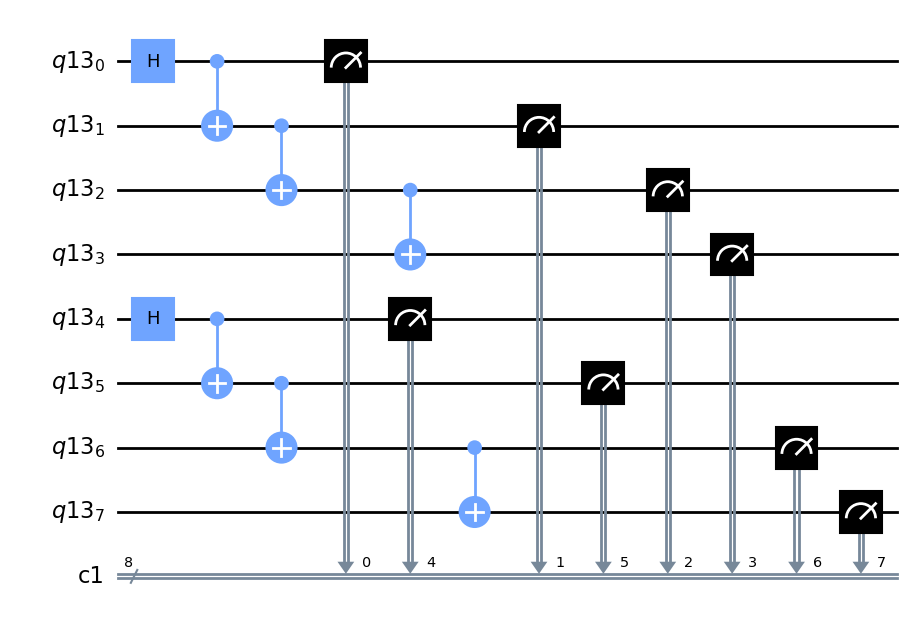

In [ ]:
size = 4

num_of_pairs = int(np.ceil(np.log2(size)))
print(num_of_pairs)

# Create the quantum registers and classical registers for measurement
q = QuantumRegister(size*num_of_pairs)
c = ClassicalRegister(size*num_of_pairs)

# Create the circuit with all registers
circ = QuantumCircuit(q, c)
for i in range(num_of_pairs):
    circ.h(i * size)
    for j in range(size-1):
        circ.cx(j + i * size, j + 1 + i * size)

# Measure all qubits and put the result in the classical registers
for i in range(size * num_of_pairs):
    circ.measure(q[i], c[i])

circ.draw('mpl')

00001111
Leader has identifier 1


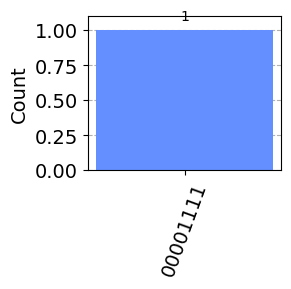

In [ ]:
num_shots = 1

# Create the simulator and run one time
backend_sim = BasicAer.get_backend('qasm_simulator')
job_sim = execute(circ, backend_sim, shots=num_shots, memory=True)
result_sim = job_sim.result().get_memory(circ)

result = result_sim[0]
print(result)

def calculate_id(c):
    s = 0
    for i in range(num_of_pairs):
        s = s * 2 + int(result[i*size])
    sys.stdout.write("Leader has identifier " + str(s))
    return s

calculate_id(c)

sys.stdout.write("\n")
plot_histogram(job_sim.result().get_counts(circ), figsize=(2.5,2))